In [97]:
import numpy as np
import pandas as pd
import yfinance as yf

In [98]:
btc = yf.download(tickers='BTC-USD', period = '1mo', interval = '1h')

[*********************100%***********************]  1 of 1 completed


In [99]:
btc

,Open,High,Low,Close,Adj Close,Volume
2021-03-03 17:00:00+00:00,51142.523438,51415.191406,50950.535156,51330.796875,51330.796875,0
2021-03-03 18:00:00+00:00,51321.148438,51584.886719,51209.511719,51235.839844,51235.839844,0
2021-03-03 19:00:00+00:00,51259.117188,51262.367188,50466.898438,50836.824219,50836.824219,0
2021-03-03 20:00:00+00:00,50840.406250,51091.546875,50558.632812,50575.242188,50575.242188,0
2021-03-03 21:00:00+00:00,50567.058594,51075.277344,50472.460938,50975.597656,50975.597656,267448320
...,...,...,...,...,...,...
2021-04-03 14:00:00+01:00,59699.074219,59845.832031,59630.937500,59821.179688,59821.179688,862715904
2021-04-03 15:00:00+01:00,59829.109375,59866.738281,59678.117188,59678.117188,59678.117188,2771066880
2021-04-03 16:00:00+01:00,59656.402344,59676.062500,59374.109375,59374.109375,59374.109375,478150656
2021-04-03 17:00:00+01:00,59360.316406,59574.117188,59200.167969,59469.765625,59469.765625,959012864


In [100]:
btc.reset_index(inplace=True)

btc

,index,Open,High,Low,Close,Adj Close,Volume
0,2021-03-03 17:00:00+00:00,51142.523438,51415.191406,50950.535156,51330.796875,51330.796875,0
1,2021-03-03 18:00:00+00:00,51321.148438,51584.886719,51209.511719,51235.839844,51235.839844,0
2,2021-03-03 19:00:00+00:00,51259.117188,51262.367188,50466.898438,50836.824219,50836.824219,0
3,2021-03-03 20:00:00+00:00,50840.406250,51091.546875,50558.632812,50575.242188,50575.242188,0
4,2021-03-03 21:00:00+00:00,50567.058594,51075.277344,50472.460938,50975.597656,50975.597656,267448320
...,...,...,...,...,...,...,...
740,2021-04-03 14:00:00+01:00,59699.074219,59845.832031,59630.937500,59821.179688,59821.179688,862715904
741,2021-04-03 15:00:00+01:00,59829.109375,59866.738281,59678.117188,59678.117188,59678.117188,2771066880
742,2021-04-03 16:00:00+01:00,59656.402344,59676.062500,59374.109375,59374.109375,59374.109375,478150656
743,2021-04-03 17:00:00+01:00,59360.316406,59574.117188,59200.167969,59469.765625,59469.765625,959012864


In [101]:
btc.rename(columns = {'index':'Date'}, inplace = True)

In [102]:
btc['Date'] = pd.to_datetime(btc['Date'])

In [103]:
btc.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-03 17:00:00+00:00,51142.523438,51415.191406,50950.535156,51330.796875,51330.796875,0
2021-03-03 18:00:00+00:00,51321.148438,51584.886719,51209.511719,51235.839844,51235.839844,0
2021-03-03 19:00:00+00:00,51259.117188,51262.367188,50466.898438,50836.824219,50836.824219,0
2021-03-03 20:00:00+00:00,50840.406250,51091.546875,50558.632812,50575.242188,50575.242188,0
2021-03-03 21:00:00+00:00,50567.058594,51075.277344,50472.460938,50975.597656,50975.597656,267448320
...,...,...,...,...,...,...
2021-04-03 14:00:00+01:00,59699.074219,59845.832031,59630.937500,59821.179688,59821.179688,862715904
2021-04-03 15:00:00+01:00,59829.109375,59866.738281,59678.117188,59678.117188,59678.117188,2771066880
2021-04-03 16:00:00+01:00,59656.402344,59676.062500,59374.109375,59374.109375,59374.109375,478150656


In [104]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

In [105]:
df = btc

In [106]:
# Function to return the SMA
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()
class SmaCross(Strategy):
    # Placeholder for calculations
    ma_short = 10
    ma_long = 20
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
        # Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

In [107]:
# reminder that we use this Backtest class
bt = Backtest(data=df, strategy=SmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(1, 84, 2),
    ma_long=range(10, 360, 2),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 6647 configurations.
  output = _optimize_grid()


ma_short  ma_long
27        50         127045.602063
3         66         126853.878344
          64         126556.090313
25        50         126517.807938
23        52         126429.596500
3         68         126181.497203
          78         125800.698062
          76         125664.300813
          74         125664.300813
5         76         125512.696453
Name: Equity Final [$], dtype: float64

<AxesSubplot:xlabel='ma_long', ylabel='ma_short'>

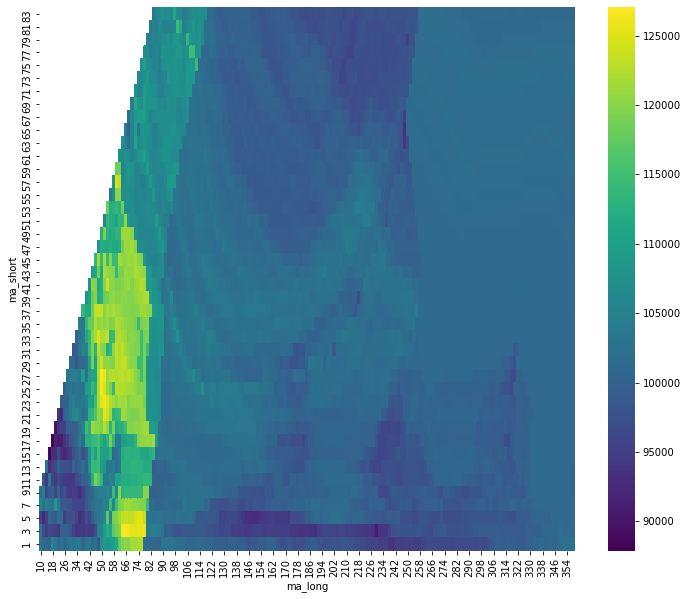

In [108]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [109]:
from backtesting import Strategy
from backtesting.lib import crossover
class SmaCross_3_66(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 3
    ma_long = 66
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

# run the backtest
bt = Backtest(data=df, strategy=SmaCross_3_66, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [110]:
bt = Backtest(data=df, strategy=SmaCross_3_66, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  """Entry point for launching an IPython kernel.


Start                                       0
End                                       744
Duration                                  744
Exposure Time [%]                     65.1007
Equity Final [$]                       126854
Equity Peak [$]                        128675
Return [%]                            26.8539
Buy & Hold Return [%]                 15.8588
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -9.21456
Avg. Drawdown [%]                    -1.52578
Max. Drawdown Duration                    397
Avg. Drawdown Duration                25.0769
# Trades                                    5
Win Rate [%]                               60
Best Trade [%]                        19.2627
Worst Trade [%]                        -2.997
Avg. Trade [%]                    

In [111]:
from backtesting import Strategy
from backtesting.lib import crossover
class SmaCross_27_50(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 27
    ma_long = 50
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

# run the backtest
bt = Backtest(data=df, strategy=SmaCross_27_50, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [112]:
bt = Backtest(data=df, strategy=SmaCross_27_50, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  """Entry point for launching an IPython kernel.


Start                                       0
End                                       744
Duration                                  744
Exposure Time [%]                     68.4564
Equity Final [$]                       127046
Equity Peak [$]                        128346
Return [%]                            27.0456
Buy & Hold Return [%]                 15.8588
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -10.5428
Avg. Drawdown [%]                    -1.83499
Max. Drawdown Duration                    334
Avg. Drawdown Duration                22.7241
# Trades                                    6
Win Rate [%]                          66.6667
Best Trade [%]                        20.1349
Worst Trade [%]                      -6.98542
Avg. Trade [%]                    

In [17]:
# Function to return the EMA
def EMA(values, n):
    return pd.Series.ewm(values, span=n).mean()
class EmaCross(Strategy):
    ma_short = 10
    ma_long = 20
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If ema1 crosses above ema2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
        # Else, if ema1 crosses below ema2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

In [23]:
# reminder that we use this Backtest class
bt = Backtest(data=df, strategy=EmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(1, 84, 2),
    ma_long=range(12, 180, 2),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 2862 configurations.
  output = _optimize_grid()


ma_short  ma_long
1         68         121462.849461
          70         121462.849461
          66         115203.165633
          64         115083.712359
          60         113969.333867
          62         113809.907359
          38         112908.660719
          40         111845.713133
          58         111807.423359
          56         111421.614219
Name: Equity Final [$], dtype: float64

<AxesSubplot:xlabel='ma_long', ylabel='ma_short'>

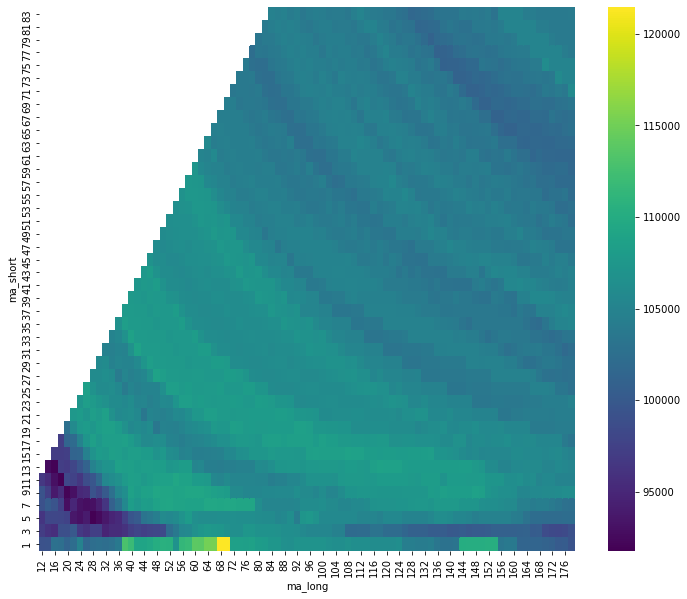

In [24]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover
class EmaCross_10_60(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 10
    ma_long = 60
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

# run the backtest
bt = Backtest(data=df, strategy=EmaCross_10_60, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

In [ ]:
# run the backtest
bt = Backtest(data=df, strategy=EmaCross_10_60, cash=100000, commission=.002)
bt.run()

In [113]:
SMA_3 = pd.Series(btc.Close).rolling(3).mean()

In [114]:
SMA_3

0               NaN
1               NaN
2      51134.486979
3      50882.635417
4      50795.888021
           ...     
740    59729.180990
741    59732.489583
742    59624.468750
743    59507.330729
744    59438.376302
Name: Close, Length: 745, dtype: float64

In [115]:
SMA_66 = pd.Series(btc.Close).rolling(66).mean()

In [116]:
SMA_66

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
740    59428.466323
741    59436.264323
742    59440.751302
743    59449.221768
744    59457.591797
Name: Close, Length: 745, dtype: float64

In [117]:
btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-03 17:00:00+00:00,51142.523438,51415.191406,50950.535156,51330.796875,51330.796875,0
1,2021-03-03 18:00:00+00:00,51321.148438,51584.886719,51209.511719,51235.839844,51235.839844,0
2,2021-03-03 19:00:00+00:00,51259.117188,51262.367188,50466.898438,50836.824219,50836.824219,0
3,2021-03-03 20:00:00+00:00,50840.406250,51091.546875,50558.632812,50575.242188,50575.242188,0
4,2021-03-03 21:00:00+00:00,50567.058594,51075.277344,50472.460938,50975.597656,50975.597656,267448320
...,...,...,...,...,...,...,...
740,2021-04-03 14:00:00+01:00,59699.074219,59845.832031,59630.937500,59821.179688,59821.179688,862715904
741,2021-04-03 15:00:00+01:00,59829.109375,59866.738281,59678.117188,59678.117188,59678.117188,2771066880
742,2021-04-03 16:00:00+01:00,59656.402344,59676.062500,59374.109375,59374.109375,59374.109375,478150656
743,2021-04-03 17:00:00+01:00,59360.316406,59574.117188,59200.167969,59469.765625,59469.765625,959012864


In [118]:
btc_close = btc[['Date', 'Close']]
btc_close

,Date,Close
0,2021-03-03 17:00:00+00:00,51330.796875
1,2021-03-03 18:00:00+00:00,51235.839844
2,2021-03-03 19:00:00+00:00,50836.824219
3,2021-03-03 20:00:00+00:00,50575.242188
4,2021-03-03 21:00:00+00:00,50975.597656
...,...,...
740,2021-04-03 14:00:00+01:00,59821.179688
741,2021-04-03 15:00:00+01:00,59678.117188
742,2021-04-03 16:00:00+01:00,59374.109375
743,2021-04-03 17:00:00+01:00,59469.765625


In [122]:
SMA_27 = pd.Series(btc.Close).rolling(27).mean()
SMA_50 = pd.Series(btc.Close).rolling(50).mean()

In [123]:
btc_close['SMA_27'] = SMA_27
btc_close['SMA_50'] = SMA_50

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
btc_close['SMA_3'] = SMA_3
btc_close['SMA_66'] = SMA_66

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
btc_close

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN
...,...,...,...,...,...,...
740,2021-04-03 14:00:00+01:00,59821.179688,59729.180990,59428.466323,59615.842014,59531.830625
741,2021-04-03 15:00:00+01:00,59678.117188,59732.489583,59436.264323,59605.152922,59546.674688
742,2021-04-03 16:00:00+01:00,59374.109375,59624.468750,59440.751302,59587.309896,59549.523906
743,2021-04-03 17:00:00+01:00,59469.765625,59507.330729,59449.221768,59587.197627,59553.294141


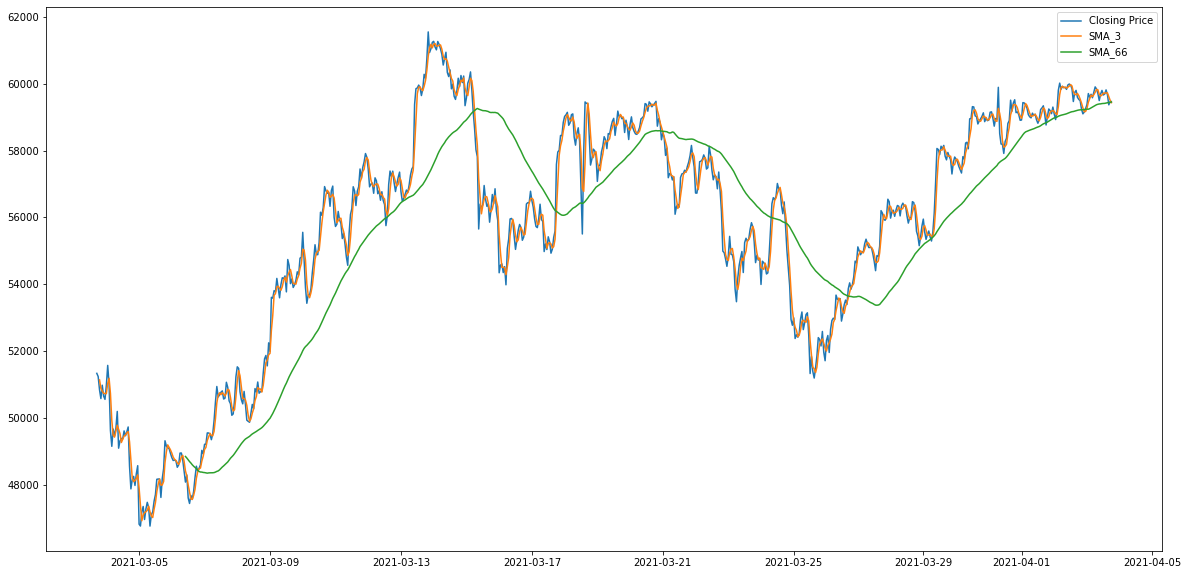

In [126]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['Close'], label='Closing Price')
plt.plot(btc_close['Date'], btc_close['SMA_3'], label='SMA_3')
plt.plot(btc_close['Date'], btc_close['SMA_66'], label='SMA_66')
plt.legend()
plt.show()

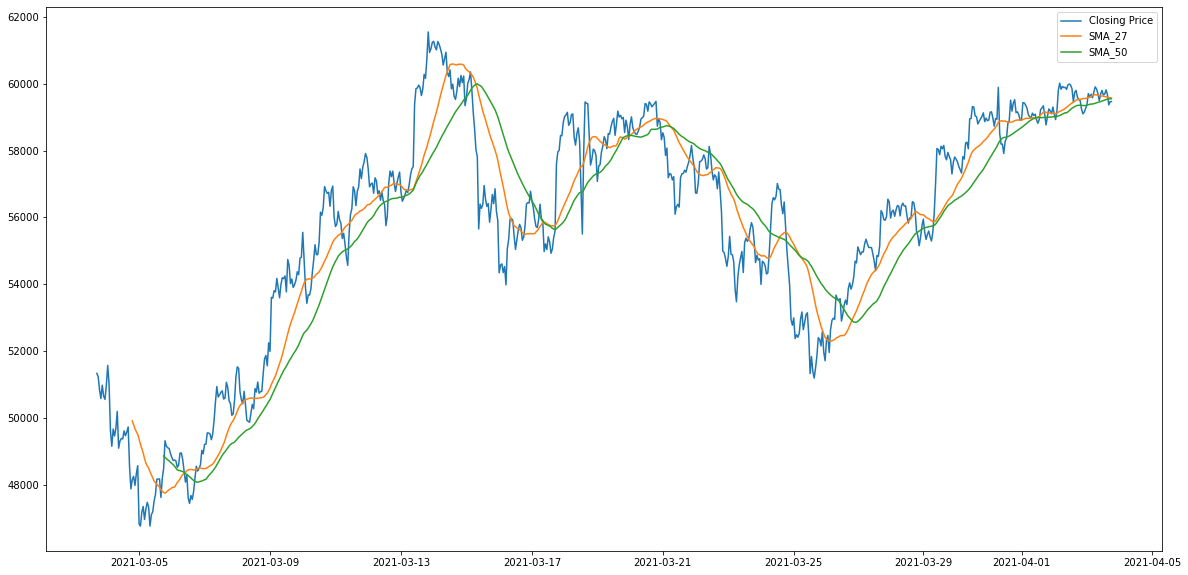

In [127]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['Close'], label='Closing Price')
plt.plot(btc_close['Date'], btc_close['SMA_27'], label='SMA_27')
plt.plot(btc_close['Date'], btc_close['SMA_50'], label='SMA_50')
plt.legend()
plt.show()

In [128]:
delta = btc['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down

In [129]:
rs

0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.242443
         ...   
740    1.241365
741    1.051870
742    0.779547
743    0.867275
744    0.868745
Name: Close, Length: 745, dtype: float64

In [130]:
btc_close['RSI'] = 100 - (100/(1 + rs))

btc_close

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419
...,...,...,...,...,...,...,...
740,2021-04-03 14:00:00+01:00,59821.179688,59729.180990,59428.466323,59615.842014,59531.830625,55.384333
741,2021-04-03 15:00:00+01:00,59678.117188,59732.489583,59436.264323,59605.152922,59546.674688,51.263976
742,2021-04-03 16:00:00+01:00,59374.109375,59624.468750,59440.751302,59587.309896,59549.523906,43.805939
743,2021-04-03 17:00:00+01:00,59469.765625,59507.330729,59449.221768,59587.197627,59553.294141,46.446020


In [144]:
exp1 = btc[['Date', 'Close']].ewm(span=12, adjust=False).mean()
exp2 = btc[['Date', 'Close']].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2

In [145]:
macd

,Close
0,0.000000
1,-7.574920
2,-45.253669
3,-95.125287
4,-101.177255
...,...
740,63.542961
741,57.274847
742,27.459891
743,11.418359


In [147]:
exp3 = macd.ewm(span=9, adjust=False).mean()
exp3

,Close
0,0.000000
1,-1.514984
2,-10.262721
3,-27.235234
4,-42.023638
...,...
740,55.399118
741,55.774263
742,50.111389
743,42.372783


In [153]:
btc_close['MACD'] = macd
btc_close['Signal'] = exp3

In [166]:
btc_close.head(60)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000,-7.574920,-1.514984
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000,-45.253669,-10.262721
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000,-95.125287,-27.235234
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419,-101.177255,-42.023638
5,2021-03-03 22:00:00+00:00,50648.527344,50733.122396,NaN,NaN,NaN,16.654258,-130.856888,-59.790288
6,2021-03-03 23:00:00+00:00,50551.007812,50725.044271,NaN,NaN,NaN,15.905917,-160.398250,-79.911881
7,2021-03-04 00:00:00+00:00,50971.988281,50723.841146,NaN,NaN,NaN,30.437257,-148.132804,-93.556065
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063
9,2021-03-04 02:00:00+00:00,51004.335938,51181.750000,NaN,NaN,NaN,37.076109,-87.078009,-91.566052


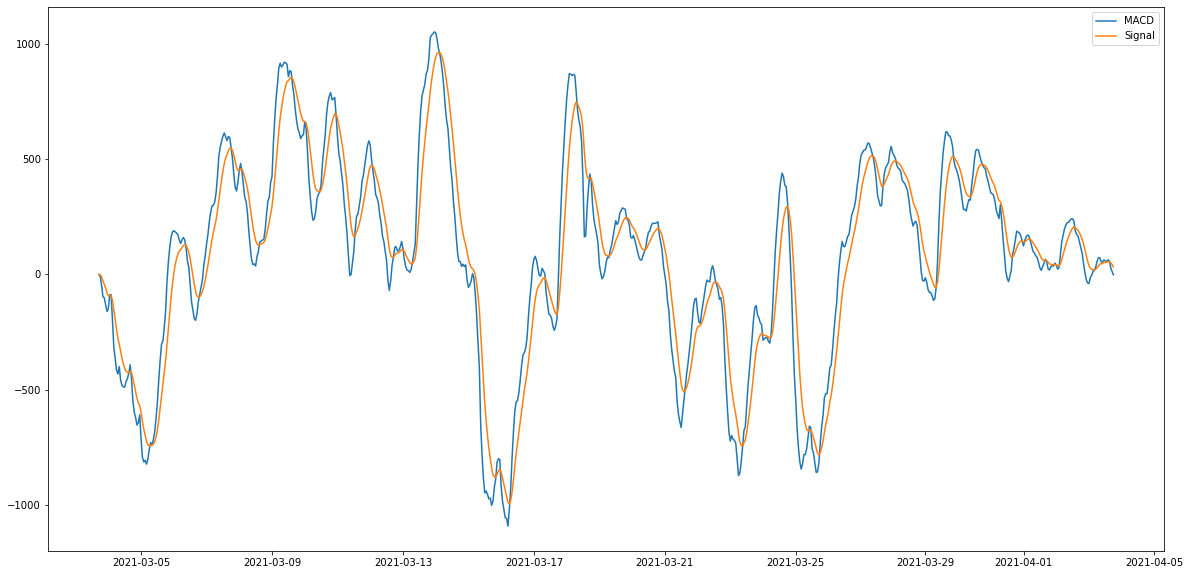

In [172]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['MACD'], label='MACD')
plt.plot(btc_close['Date'], btc_close['Signal'], label='Signal')
plt.legend()
plt.show()

In [207]:
btc_close['Trend'] = 0
for index, row in btc_close.iterrows():
    try:
        prev_signal = btc_close.at[index - 1, 'Signal']
        current_signal = btc_close.at[index, 'Signal']
        if index == 0 or index == 1:
            continue
        else:
            if prev_signal > current_signal:
                btc_close.at[index, 'Trend'] = -1
            else:
                btc_close.at[index, 'Trend'] = 1
    except:
        pass

In [208]:
btc_close.head(50)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000,-7.574920,-1.514984,0,
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000,-45.253669,-10.262721,-1,
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000,-95.125287,-27.235234,-1,
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419,-101.177255,-42.023638,-1,
5,2021-03-03 22:00:00+00:00,50648.527344,50733.122396,NaN,NaN,NaN,16.654258,-130.856888,-59.790288,-1,
6,2021-03-03 23:00:00+00:00,50551.007812,50725.044271,NaN,NaN,NaN,15.905917,-160.398250,-79.911881,-1,
7,2021-03-04 00:00:00+00:00,50971.988281,50723.841146,NaN,NaN,NaN,30.437257,-148.132804,-93.556065,-1,
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063,1,
9,2021-03-04 02:00:00+00:00,51004.335938,51181.750000,NaN,NaN,NaN,37.076109,-87.078009,-91.566052,1,


In [263]:
btc_close['Buy/Sell'] = ""
for index, row in btc_close.iterrows():
    try:
        current_trend = btc_close.at[index, 'Trend']
        prev_trend = btc_close.at[index - 1, 'Trend']
        #SMA_3 = btc_close.at[index, 'SMA_3']
        #SMA_66 = btc_close.at[index, 'SMA_66']
        #isNaN_prev = np.isnan(prev_trend)
        #isNaN_current = np.isnan(current_trend)
        if prev_trend == 0 or current_trend == 0:
            pass
        elif prev_trend != current_trend:
            print("Trend different")
            print(f"{prev_trend} and {current_trend}")
            if prev_trend == -1:
                btc_close.at[index, 'Buy/Sell'] = 'Buy'
            else:
                btc_close.at[index, 'Buy/Sell'] = 'Sell'
        else:
            continue
    except:
        pass

Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1
Trend different
-1 and 1
Trend different
1 and -1


In [265]:
btc_close['Cross'] = ""
for index, row in btc_close.iterrows():
    try:
        #current_trend = btc_close.at[index, 'Trend']
        #prev_trend = btc_close.at[index - 1, 'Trend']
        curr_SMA_3 = btc_close.at[index, 'SMA_3']
        curr_SMA_66 = btc_close.at[index, 'SMA_66']
        prev_SMA_3 = btc_close.at[index - 1, 'SMA_3']
        prev_SMA_66 = btc_close.at[index - 1, 'SMA_66']
        curr_isNaN_3 = np.isnan(curr_SMA_3)
        curr_isNaN_66 = np.isnan(curr_SMA_66)
        prev_isNaN_3 = np.isnan(prev_SMA_3)
        prev_isNaN_66 = np.isnan(prev_SMA_66)
        if curr_isNaN_3 == True or curr_isNaN_66 == True or prev_isNaN_3 == True or prev_isNaN_66 == True:
            pass
        else:
            if prev_SMA_3 < prev_SMA_66 and curr_SMA_3 > curr_SMA_66:
                btc_close.at[index, 'Cross'] = 'Bull Cross'
            elif prev_SMA_3 > prev_SMA_66 and curr_SMA_3 < curr_SMA_66:
                btc_close.at[index, 'Cross'] = 'Bear Cross'
            else:
                continue
    except:
        pass

In [267]:
btc_close.head(60)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell,Bollinger High,Bollinger Low,Cross
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,,NaN,NaN,
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000,-7.574920,-1.514984,0,,NaN,NaN,
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000,-45.253669,-10.262721,-1,,51396.606320,50872.367639,
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000,-95.125287,-27.235234,-1,,51215.308402,50549.962431,
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419,-101.177255,-42.023638,-1,,50999.180801,50592.595240,
5,2021-03-03 22:00:00+00:00,50648.527344,50733.122396,NaN,NaN,NaN,16.654258,-130.856888,-59.790288,-1,,50946.285168,50519.959624,
6,2021-03-03 23:00:00+00:00,50551.007812,50725.044271,NaN,NaN,NaN,15.905917,-160.398250,-79.911881,-1,,50947.440907,50502.647634,
7,2021-03-04 00:00:00+00:00,50971.988281,50723.841146,NaN,NaN,NaN,30.437257,-148.132804,-93.556065,-1,,50944.205084,50503.477207,
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063,1,Buy,51542.127986,50519.153264,
9,2021-03-04 02:00:00+00:00,51004.335938,51181.750000,NaN,NaN,NaN,37.076109,-87.078009,-91.566052,1,,51517.443918,50846.056082,


In [213]:
btc_close.head(50)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000,-7.574920,-1.514984,0,
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000,-45.253669,-10.262721,-1,
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000,-95.125287,-27.235234,-1,
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419,-101.177255,-42.023638,-1,
5,2021-03-03 22:00:00+00:00,50648.527344,50733.122396,NaN,NaN,NaN,16.654258,-130.856888,-59.790288,-1,
6,2021-03-03 23:00:00+00:00,50551.007812,50725.044271,NaN,NaN,NaN,15.905917,-160.398250,-79.911881,-1,
7,2021-03-04 00:00:00+00:00,50971.988281,50723.841146,NaN,NaN,NaN,30.437257,-148.132804,-93.556065,-1,
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063,1,Buy
9,2021-03-04 02:00:00+00:00,51004.335938,51181.750000,NaN,NaN,NaN,37.076109,-87.078009,-91.566052,1,


In [244]:
rolling_mean = btc_close['Close'].rolling(3).mean()
rolling_std = btc_close['Close'].rolling(3).std()

In [245]:
btc_close['Bollinger High'] = rolling_mean + (rolling_std * 1)
btc_close['Bollinger Low'] = rolling_mean - (rolling_std * 1)     

In [246]:
btc_close.head(50)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell,Bollinger High,Bollinger Low
0,2021-03-03 17:00:00+00:00,51330.796875,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,,NaN,NaN
1,2021-03-03 18:00:00+00:00,51235.839844,NaN,NaN,NaN,NaN,0.000000,-7.574920,-1.514984,0,,NaN,NaN
2,2021-03-03 19:00:00+00:00,50836.824219,51134.486979,NaN,NaN,NaN,0.000000,-45.253669,-10.262721,-1,,51396.606320,50872.367639
3,2021-03-03 20:00:00+00:00,50575.242188,50882.635417,NaN,NaN,NaN,0.000000,-95.125287,-27.235234,-1,,51215.308402,50549.962431
4,2021-03-03 21:00:00+00:00,50975.597656,50795.888021,NaN,NaN,NaN,19.513419,-101.177255,-42.023638,-1,,50999.180801,50592.595240
5,2021-03-03 22:00:00+00:00,50648.527344,50733.122396,NaN,NaN,NaN,16.654258,-130.856888,-59.790288,-1,,50946.285168,50519.959624
6,2021-03-03 23:00:00+00:00,50551.007812,50725.044271,NaN,NaN,NaN,15.905917,-160.398250,-79.911881,-1,,50947.440907,50502.647634
7,2021-03-04 00:00:00+00:00,50971.988281,50723.841146,NaN,NaN,NaN,30.437257,-148.132804,-93.556065,-1,,50944.205084,50503.477207
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063,1,Buy,51542.127986,50519.153264
9,2021-03-04 02:00:00+00:00,51004.335938,51181.750000,NaN,NaN,NaN,37.076109,-87.078009,-91.566052,1,,51517.443918,50846.056082


In [254]:
btc_close.loc[btc_close['Buy/Sell'] != ''].head(20)

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell,Bollinger High,Bollinger Low
8,2021-03-04 01:00:00+00:00,51568.925781,51030.640625,NaN,NaN,NaN,44.960571,-89.216056,-92.688063,1,Buy,51542.127986,50519.153264
10,2021-03-04 03:00:00+00:00,49616.593750,50729.951823,NaN,NaN,NaN,25.321835,-195.113639,-112.275570,-1,Sell,51734.623447,49725.280199
23,2021-03-04 16:00:00+00:00,49724.410156,49587.348958,NaN,NaN,NaN,41.981402,-392.030174,-419.363670,1,Buy,49718.925288,49455.772629
24,2021-03-04 17:00:00+00:00,48545.390625,49281.796875,NaN,NaN,NaN,31.900655,-453.690086,-426.228953,-1,Sell,49923.869686,48639.724064
38,2021-03-05 07:00:00+00:00,47322.675781,47351.555990,NaN,48491.654369,NaN,37.886010,-728.938362,-740.403312,1,Buy,47455.561197,47247.550782
39,2021-03-05 08:00:00+00:00,46755.410156,47181.678385,NaN,48384.011719,NaN,33.763061,-742.278240,-740.778297,-1,Sell,47557.819527,46805.537244
40,2021-03-05 09:00:00+00:00,47096.542969,47058.209635,NaN,48296.648582,NaN,38.123934,-717.057826,-736.034203,1,Buy,47343.778639,46772.640632
64,2021-03-06 09:00:00+00:00,48410.093750,48698.078125,NaN,48333.785156,48363.236172,47.305175,114.822974,127.133867,-1,Sell,48967.633884,48428.522366
74,2021-03-06 19:00:00+00:00,48403.984375,48386.723958,48428.878255,48478.809317,48069.806016,52.071702,-86.288813,-95.836808,1,Buy,48558.800220,48214.647696
98,2021-03-07 19:00:00+00:00,50421.125000,50613.154948,48787.218987,49789.884404,49198.267578,58.135828,504.202863,539.238943,-1,Sell,50874.960104,50351.349792


In [262]:
btc_close.loc[(btc_close['Buy/Sell'] == 'Buy') & (btc_close['SMA_3'] >= btc_close['SMA_66'])]

,Date,Close,SMA_3,SMA_66,SMA_27,SMA_50,RSI,MACD,Signal,Trend,Buy/Sell,Bollinger High,Bollinger Low
104,2021-03-08 01:00:00+00:00,51480.390625,51410.949219,49111.881274,50297.020110,49416.130547,68.182750,481.903505,457.809389,1,Buy,51572.365142,51249.533295
118,2021-03-08 15:00:00+00:00,51071.273438,50905.536458,49620.495028,50590.313947,49968.646641,59.547956,140.932297,129.315970,1,Buy,51058.208691,50752.864226
163,2021-03-10 12:00:00+00:00,55251.804688,55008.529948,52684.482481,54371.033999,53381.240078,62.186455,391.044518,366.170732,1,Buy,55219.218517,54797.841379
188,2021-03-11 13:00:00+00:00,56920.390625,56424.562500,54751.285275,55988.370370,55222.995703,62.806205,193.312087,168.944274,1,Buy,56862.639825,55986.485175
216,2021-03-12 17:00:00+00:00,57224.902344,57200.281250,56128.807410,56965.444010,56557.847969,55.954466,75.997404,74.509238,1,Buy,57403.622986,56996.939514
230,2021-03-13 07:00:00+00:00,57269.914062,56995.080729,56626.459517,56832.230035,56737.380703,56.322348,53.992332,47.198328,1,Buy,57258.481957,56731.679502
337,2021-03-17 18:00:00+00:00,57588.777344,56195.153646,56182.756333,55818.579861,55662.205625,66.859673,-5.034047,-140.321337,1,Buy,57405.841307,54984.465985
360,2021-03-18 17:00:00+00:00,59406.089844,59428.524740,56581.623698,58113.272280,57050.462813,59.564217,435.841316,419.520078,1,Buy,59456.834368,59400.215111
375,2021-03-19 08:00:00+00:00,58513.187500,58300.743490,57237.062618,58115.086661,57621.179219,54.825246,104.606346,84.829776,1,Buy,58527.372245,58074.114734
401,2021-03-20 10:00:00+00:00,59037.972656,58992.375000,58428.514205,58772.535156,58435.502969,56.766077,114.166003,107.904171,1,Buy,59034.908353,58949.841647
